In [2]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  []


In [3]:
(train_ds, val_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)
#tfds.show_examples(train_ds, ds_info)

In [4]:
# gets in a dataset and returns target values
def prepare_data(dataset, batch_size, noise_variance):
    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, targets: (tf.cast(img, tf.float32), targets))

    # convert image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, targets: ((img/128.)-1., targets))

    # replace targets with initial img, replace initial img with img+noise
    dataset = dataset.map(lambda img, target: (img + tf.random.normal(img.shape, mean=0, stddev=noise_variance), img))

    # clip min value to -1 and max value to +1
    dataset = dataset.map(lambda img, target: (tf.clip_by_value(img, clip_value_min=-1, clip_value_max=1), target))

    dataset = dataset.cache()
    dataset = dataset.shuffle(4096)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [142]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Encoder, self).__init__()
  
        self.my_layers = [tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(14, 14, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(64, activation='relu')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [6]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Decoder, self).__init__()

        self.my_layers = [tf.keras.layers.Dense(14 * 14, activation='relu'),
                          tf.keras.layers.Reshape((14, 14, 1)),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
                         ]

    @tf.function
    def call(self, x, training=False):
        for layer in self.my_layers:
            x = layer(x)
        return x

In [132]:
class Autoencoder(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()


    @tf.function
    def call(self, x, training=False):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
# overall hyperparameters to compare with and without overfitting precautions methods
epochs = 10
batch_size = 64
noise_variance = 0.5

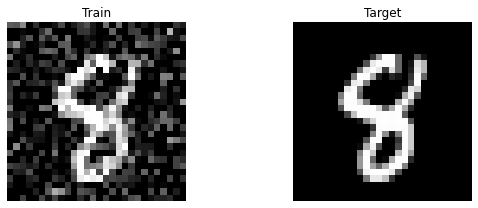

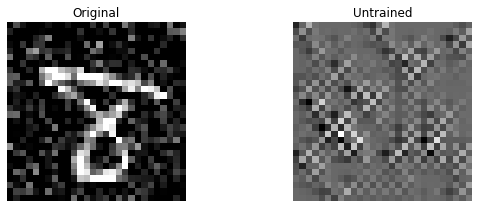

In [125]:
model = Autoencoder()

train_dataset = prepare_data(train_ds, batch_size, noise_variance)
val_dataset = prepare_data(val_ds, batch_size, noise_variance)

for img, label in train_dataset.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Train')
    plt.axis('off')
    plt.imshow(img[0,:,:,0], cmap='gray')

    plt.subplot(122)
    plt.title('Target')
    plt.axis('off')
    plt.imshow(label[0,:,:,0], cmap='gray')

    plt.tight_layout()
    plt.show()

for img, label in train_dataset.take(1):
    plt.figure(figsize=(9, 3))
    
    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img[0,:,:,0], cmap='gray')

    plt.subplot(122)
    plt.title('Untrained')
    plt.axis('off')
    plt.imshow(model(img)[0,:,:,0], cmap='gray')

    plt.tight_layout()
    plt.show()

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='mean_squared_error'
              )

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=batch_size,
                    epochs=15)

model.summary()

Epoch 1/15
938/938 [==============================] - 55s 58ms/step - loss: 0.9218 - val_loss: 0.8643
Epoch 2/15
938/938 [==============================] - 54s 57ms/step - loss: 0.8613 - val_loss: 0.8579
Epoch 3/15
938/938 [==============================] - 54s 57ms/step - loss: 0.8564 - val_loss: 0.8537
Epoch 4/15
938/938 [==============================] - 54s 57ms/step - loss: 0.8534 - val_loss: 0.8505
Epoch 5/15
938/938 [==============================] - 57s 60ms/step - loss: 0.8519 - val_loss: 0.8501
Epoch 6/15
938/938 [==============================] - 56s 59ms/step - loss: 0.8511 - val_loss: 0.8490
Epoch 7/15
938/938 [==============================] - 54s 57ms/step - loss: 0.8506 - val_loss: 0.8481
Epoch 8/15
938/938 [==============================] - 55s 58ms/step - loss: 0.8502 - val_loss: 0.8483
Epoch 9/15
938/938 [==============================] - 55s 59ms/step - loss: 0.8499 - val_loss: 0.8480
Epoch 10/15
938/938 [==============================] - 56s 60ms/step - loss: 0.849

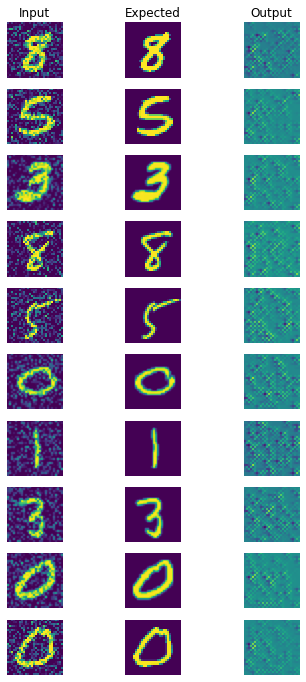

In [137]:
# Plot example images
figure = plt.figure(figsize=(6, 12))
rows = 10
cols = 3

def show_image(img, i, name):
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.reshape((28, 28)))
  plt.axis('off')
  if i < 4:
    plt.title(name)

i = 1
for imgs, targets in val_dataset.shuffle(4096).take(rows):
  output = model(imgs[0].reshape((1, 28, 28, 1)))
  
  show_image(imgs[0], i, 'Input')
  i += 1

  show_image(targets[0], i, 'Expected')
  i += 1

  show_image(output, i, 'Output')
  i += 1


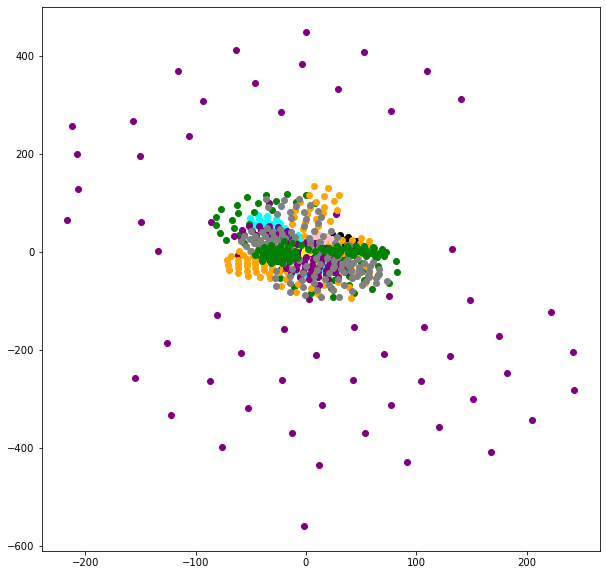

In [138]:
from sklearn.manifold import TSNE
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

color_dict = {0: "black",
              1: "green",
              2: "red",
              3: "yellow",
              4: "pink",
              5: "blue",
              6: "orange",
              7: "purple",
              8: "cyan",
              9: "grey",
              }


plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)

def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range


for old, new in zip(train_ds.take(20), train_dataset.take(20)):
    _, label = old
    imgs, imgs_label = new 

    output = model.encoder(imgs[0].reshape((1, 28, 28, 1))).reshape(-1, 1)

    output_embedded = TSNE(n_components=2).fit_transform(output)

    x = output_embedded[:, 0]
    y = output_embedded[:, 1]

    #x = scale_to_01_range(x)
    #y = scale_to_01_range(y)
    plt.plot(x, y, 'o', color=color_dict[label.numpy()])


The points of the specific labels always follow a pattern. However the points arent clustered according to their labels, they much more overlap.
We expected a pattern in which the different labels are clustered based on their labels and not to follow a pattern.

In [144]:

from scipy import interpolate

figure = plt.figure(figsize=(6, 12))
rows = 10
cols = 3

def show_image(img, i, name):
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.reshape((28, 28)))
  plt.axis('off')
  if i < 4:
    plt.title(name)

i = 1

for img, target in val_dataset.shuffle(4096).take(rows):
    img_1, target_1 = img, target


for img, target in val_dataset.shuffle(4096).take(rows):
    img_2, target_2 = img, target

embedded_1 = model.encoder(img_1[0].reshape((1, 28, 28, 1)))
embedded_2 = model.encoder(img_2[0].reshape((1, 28, 28, 1)))

interpol = interpolate.interp1d(embedded_1.numpy()[0], embedded_2.numpy()[0], kind='linear')

minima = min(np.min(embedded_1[0]), np.min(embedded_2[0])).numpy()
maxima = max(np.max(embedded_1[0]), np.max(embedded_2[0])).numpy()
steps = np.linspace(minima, maxima, 14*14)

embedded_new = interpol(steps)
embedded_new = tf.convert_to_tensor(embedded_new)

print(embedded_new)
output_new = model.decoder(embedded_new)
print(output_new)
  
"""show_image(img_1[0], i, 'first img')
i += 1

show_image(img_2[0], i, 'second img')
i += 1

show_image(output, i, 'interpolation')
i += 1"""

tf.Tensor(
[       nan 0.00146419 0.03433949 0.0672148  0.06792105 0.03316399
 0.00023671 0.01983471 0.01469506 0.00955541 0.00441576 0.00132575
 0.01073855 0.02015135 0.02956416 0.03897696 0.04838976 0.05780257
 0.06721537 0.07662817 0.05279679 0.02854592 0.00429504 0.01479193
 0.03972497 0.064658   0.08959103 0.11452406 0.13945709 0.1250437
 0.09007994 0.05511618 0.02132906 0.02128913 0.09543055 0.1486953
 0.04867784 0.01181647 0.03483676 0.05785705 0.08087734 0.10389763
 0.12691792 0.14993821 0.1729585  0.17523818 0.16344309 0.15164801
 0.13985293 0.10153426 0.05888092 0.06702115 0.08859726 0.11017338
 0.13174949 0.13862555 0.10060092 0.0625763  0.02455167 0.05574899
 0.05416225 0.03240239 0.03910659 0.05766043 0.07621427 0.09476811
 0.11332195 0.13187579 0.15042963 0.16898347 0.15321472 0.1283284
 0.10344208 0.07855576 0.05366944 0.02878312 0.14203449 0.14151021
 0.14098593 0.14046166 0.13993738 0.1394131  0.13888882 0.13836454
 0.13784027 0.13731599 0.13679171 0.13626743 0.1357431

ValueError: Exception encountered when calling layer "decoder_1" (type Decoder).

in user code:

    File "C:\Users\JULIAN~1\AppData\Local\Temp/ipykernel_10192/3469720741.py", line 16, in call  *
        x = layer(x)
    File "c:\Users\Julian Unland\anaconda3\envs\ki_uebungen\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Julian Unland\anaconda3\envs\ki_uebungen\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Input 0 of layer "dense_3" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (196,)


Call arguments received by layer "decoder_1" (type Decoder):
  • x=tf.Tensor(shape=(196,), dtype=float32)
  • training=False

<Figure size 432x864 with 0 Axes>